## Natural Language Processing COMP3225

CRF Named Entity Recognition (NER) lab
Stuart Middleton, 18/09/2020

This lab will provide practical experience with named entity recongition (NER) software trained to label named entities (NE's) within English sentences using a Conditional Random Field (CRF) model. You will learn how to use the CRF model to label NE's and adjust features to deliver better performance. You will explore how changing the L1 regularization and using all possible transitions changes the learnt transition weights and thus the type of patterns learnt. Finally you will use a randomized hyperparameter search to find an optimal set of hyperparameters for your CRF NER model.

# Part 1

# Pre-requisites
You will need python3. The code below will work OK on a CPU only machine. Increasing the number of training files and iterations will significantly improve the quality of NER performance if you are prepared to wait for the longer compute to complete.

# Task 1 - Install pre-requistes and run the baseline NER

Further reading: [Scikit Learn CRF model](https://sklearn-crfsuite.readthedocs.io/en/latest/api.html#module-sklearn_crfsuite)

Further reading: [CRF paper](https://repository.upenn.edu/cis_papers/159/) 

Further reading: Course Text - Speech and Language Processing >> Information Extraction >> Named Entity Recognition 

First install python3 and the pre-requisite libraries needed for this tutorial.

```
python3 -m pip install numpy
python3 -m pip install tensorflow-gpu
python3 -m pip install sklearn
python3 -m pip install sklearn_crfsuite
python3 -m pip install eli5
python3 -m pip install matplotlib
python3 -m pip install notebook

unzip package for lab
jupyter notebook
==> will open browser windows from localhost:8888
==> load the lab .ipynb file
```

Create a new python code file for your work.

Import this labs required python3 libraries.

In [2]:
import sys, codecs, json, math, time, warnings
warnings.simplefilter( action='ignore', category=FutureWarning )

import nltk, scipy, sklearn, sklearn_crfsuite, sklearn_crfsuite.metrics, eli5
from sklearn.metrics import make_scorer
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display    

import logging
import tensorflow as tf
import absl.logging
formatter = logging.Formatter('[%(levelname)s|%(filename)s:%(lineno)s %(asctime)s] %(message)s')
absl.logging.get_absl_handler().setFormatter(formatter)
absl.logging._warn_preinit_stderr = False
logger = tf.get_logger()
logger.setLevel(logging.INFO)

We will now define the hyperparameters used for the model.

In [3]:
# number of CRF iterations to train for. Using 150 will provide much better results, but take a lot longer to compute.
#max_iter = 20

#so then try 150? Why not if youre gonna leave it overnight then should be ok
max_iter = 150

# number of ontonotes training files to load. Using a value of None will load the entire dataset, taking the longest
# to train but providing a much larger sentence corpus to train over and thus is able to learn a larger vocabulary.
max_files = 100

#again, see if it will make it much slower or not
#max_files = None

# set of NE label types to display in results. this is simply to limit the amount of logging that is perfoemed later
# when displaying details such as state transitions and top N features per state.
display_label_subset = [ 'B-DATE', 'I-DATE', 'B-GPE', 'I-GPE', 'B-PERSON', 'I-PERSON', 'O' ]

# ^^ these are simply the NER label things from the lecture i.e. before, inside, outside

Next we define a function to load a parsed JSON formatted file with the ontonotes 5.0 dataset. The dataset is parsed and training and testset created, each a list of sentences constisting of lists of (token, POS_tag, NER_IOB_tag) tuples. IOB tagging is a scheme defining Begin, Inside, Outside tags for labels.

For example "I like New York in the spring" might be tagged "O O B-LOC I-LOC O O O" for the named entity "New York".

Ontonotes is an annotated dataset created from various genres of text (news, conversational telephone speech, weblogs, usenet newsgroups, broadcast, talk shows) in three languages (English, Chinese, and Arabic). Annotations include structural information (syntax and predicate argument structure) and shallow semantics (word sense linked to an ontology and coreference). We will only use a parsed version here with the words, POS tags and NER tags.

Further reading: [Ontonotes 5.0 dataset](https://catalog.ldc.upenn.edu/LDC2013T19)

In [4]:
#just used for reading in the dataset
def create_dataset( max_files = None ) :
	dataset_file = 'ontonotes_parsed.json'
    
	# load parsed ontonotes dataset
	readHandle = codecs.open( dataset_file, 'r', 'utf-8', errors = 'replace' )
	str_json = readHandle.read()
	readHandle.close()
	dict_ontonotes = json.loads( str_json )

	# make a training and test split
	list_files = list( dict_ontonotes.keys() )
	if len(list_files) > max_files :
		list_files = list_files[ :max_files ]
	nSplit = math.floor( len(list_files)*0.9 )
	list_train_files = list_files[ : nSplit ]
	list_test_files = list_files[ nSplit : ]

	# sent = (tokens, pos, IOB_label)
	list_train = []
	for str_file in list_train_files :
		for str_sent_index in dict_ontonotes[str_file] :
			# ignore sents with non-PENN POS tags
			if 'XX' in dict_ontonotes[str_file][str_sent_index]['pos'] :
				continue
			if 'VERB' in dict_ontonotes[str_file][str_sent_index]['pos'] :
				continue
			list_entry = []
			# compute IOB tags for named entities (if any)
			ne_type_last = None
			for nTokenIndex in range(len(dict_ontonotes[str_file][str_sent_index]['tokens'])) :
				strToken = dict_ontonotes[str_file][str_sent_index]['tokens'][nTokenIndex]
				strPOS = dict_ontonotes[str_file][str_sent_index]['pos'][nTokenIndex]
				ne_type = None
				if 'ne' in dict_ontonotes[str_file][str_sent_index] :
					dict_ne = dict_ontonotes[str_file][str_sent_index]['ne']
					if not 'parse_error' in dict_ne :
						for str_NEIndex in dict_ne :
							if nTokenIndex in dict_ne[str_NEIndex]['tokens'] :
								ne_type = dict_ne[str_NEIndex]['type']
								break
				if ne_type != None :
					if ne_type == ne_type_last :
						strIOB = 'I-' + ne_type
					else :
						strIOB = 'B-' + ne_type
				else :
					strIOB = 'O'
				ne_type_last = ne_type
				list_entry.append( ( strToken, strPOS, strIOB ) )
			list_train.append( list_entry )
	list_test = []
	for str_file in list_test_files :
		for str_sent_index in dict_ontonotes[str_file] :
			# ignore sents with non-PENN POS tags
			if 'XX' in dict_ontonotes[str_file][str_sent_index]['pos'] :
				continue
			if 'VERB' in dict_ontonotes[str_file][str_sent_index]['pos'] :
				continue
			list_entry = []
			# compute IOB tags for named entities (if any)
			ne_type_last = None
			for nTokenIndex in range(len(dict_ontonotes[str_file][str_sent_index]['tokens'])):
				strToken = dict_ontonotes[str_file][str_sent_index]['tokens'][nTokenIndex]
				strPOS = dict_ontonotes[str_file][str_sent_index]['pos'][nTokenIndex]
				ne_type = None
				if 'ne' in dict_ontonotes[str_file][str_sent_index] :
					dict_ne = dict_ontonotes[str_file][str_sent_index]['ne']
					if not 'parse_error' in dict_ne :
						for str_NEIndex in dict_ne :
							if nTokenIndex in dict_ne[str_NEIndex]['tokens'] :
								ne_type = dict_ne[str_NEIndex]['type']
								break
				if ne_type != None :
					if ne_type == ne_type_last :
						strIOB = 'I-' + ne_type
					else :
						strIOB = 'B-' + ne_type
				else :
					strIOB = 'O'
				ne_type_last = ne_type
				list_entry.append( ( strToken, strPOS, strIOB ) )
			list_test.append( list_entry )
	return list_train, list_test

Now we defined some helper functions to generate feature sets for each sentence, which the CRF model will use to train with. The word2features_func() function provided as an argument does all the work, and we will define several versions of it later.

In [5]:
def sent2features(sent, word2features_func = None):
	return [word2features_func(sent, i) for i in range(len(sent))]

#ah see, so a sentence is a list of 3 tuples, of a token, postag and NER/BIO tag
def sent2labels(sent):
	return [label for token, postag, label in sent]

def sent2tokens(sent):
	return [token for token, postag, label in sent]

def print_F1_scores( micro_F1 ) :
	for label in micro_F1 :
		logger.info( "%-15s -> f1 %0.2f ; prec %0.2f ; recall %0.2f" % ( label, micro_F1[label]['f1-score'], micro_F1[label]['precision'], micro_F1[label]['recall'] ) )

def print_transitions(trans_features):
	for (label_from, label_to), weight in trans_features:
		logger.info( "%-15s -> %-15s %0.6f" % (label_from, label_to, weight) )

def print_state_features(state_features):
	for (attr, label), weight in state_features:
		logger.info( "%0.6f %-15s %s" % (weight, label, attr) )

Now we can write a function to train the CRF model on the ontonotes corpus, and then run the trained model to compute a macro F1 score on the testset.

First we load the corpus and then use the helper functions to generate lists of features for every token in the dataset. We curate a set of NE labels and remove the 'O' label. This is done because the majority of words are not named entities, and so 'O' tags severly imbalance the dataset. We want a CRF model that has a good F1 score across non-O tags, and if we left the 'O' tag in the F1 score would be dominated by the 'O' tag performance only.

Next we train the CRF model and log the weights it has learnt. We then run the trained model on the testset and report the macro F1 score results. We also log information about the state transitions and position/negative weighted features as this can reveal what has really been learnt by the CRF model.

In [6]:
#why tf does he call it sent thats abit confusing but oh well, its actually sentence

def exec_task( max_files = 10, max_iter = 20, display_label_subset = [], word2features_func = None, train_crf_model_func = None ) :
	logger.info( 'max iterations = ' + repr(max_iter) )
	logger.info( 'word2features_func = ' + word2features_func.__name__  )
	logger.info( 'train_crf_model_func = ' + train_crf_model_func.__name__  )

	# make a dataset from english NE labelled ontonotes sents
	train_sents, test_sents = create_dataset( max_files = max_files )
	logger.info( '# training sents = ' + str(len(train_sents)) )
	logger.info( '# test sents = ' + str(len(test_sents)) )

	# print example sentence (1st sentENCE)
	logger.info( '' )
	logger.info( 'Example training sent annotated with IOB tags  = ' + repr(train_sents[0]) )

	# create feature vectors for every sentENCe
	X_train = [sent2features(s, word2features_func = word2features_func) for s in train_sents]
	Y_train = [sent2labels(s) for s in train_sents]

	X_test = [sent2features(s, word2features_func = word2features_func) for s in test_sents]
	Y_test = [sent2labels(s) for s in test_sents]

	# get the label set
	set_labels = set([])
	for data in [Y_train,Y_test] :
		for n_sent in range(len(data)) :
			for str_label in data[n_sent] :
				set_labels.add( str_label )
	labels = list( set_labels )
	logger.info( '' )
	logger.info( 'labels = ' + repr(labels) )

	# remove 'O' label as we are not usually interested in how well 'O' is predicted
	#labels = list( crf.classes_ )
	labels.remove('O')

	# print example feature vector (12th word of 1st sent)
	logger.info( '' )
	logger.info( 'Example training feature = ' + repr(X_train[0][10]) )

	# Train CRF model
	crf = train_crf_model_func( X_train, Y_train, max_iter, labels )

	logger.info('Label transition weights learnt from dataset (for a subset of labels)')
	display( eli5.show_weights(crf, top=10, targets = display_label_subset, show=['transition_features']) )

	logger.info('Top 10 features per-target (for a subset of labels)')
	display( eli5.show_weights(crf, top=20, targets = display_label_subset, show=['targets']) )

	# compute the macro F1 score (F1 for instances of each label class averaged) in the test set
	Y_pred = crf.predict( X_test )
	sorted_labels = sorted(
		labels, 
		key=lambda name: (name[1:], name[0])
	)
	macro_scores = sklearn_crfsuite.metrics.flat_classification_report( Y_test, Y_pred, labels=sorted_labels, digits=3, output_dict = True )
	logger.info( '' )
	logger.info( 'macro F1 scores'  )
	print_F1_scores( macro_scores )

	# inspect the transitions
	logger.info( '' )
	logger.info("Top 10 likely state transitions")
	print_transitions( Counter(crf.transition_features_).most_common(10) )

	logger.info( '' )
	logger.info("Top 10 unlikely state transitions")
	print_transitions( Counter(crf.transition_features_).most_common()[-10:] )

	# inspect the states
	logger.info( '' )
	logger.info("Top 10 positive states")
	print_state_features(Counter(crf.state_features_).most_common(10))

	logger.info( '' )
	logger.info("Top 10 negative states")
	print_state_features(Counter(crf.state_features_).most_common()[-10:])


Now we will define a basic function to create set of features for a token position within a sentence. This function uses only the word and POS tag, and will look ahead and behind by one token index position.

In [7]:
#generates a dictionary of features for the sentence (the 3-tuple list described earlier) and current posaition
def task1_word2features(sent, i):

	word = sent[i][0]
	postag = sent[i][1]

	features = {
		# basic features - token and POS tag
		'word' : word,
		'postag': postag,
	}
	if i > 0:
		# features for previous word
        #[0] gets the word from the 3tuple
		word_prev = sent[i-1][0]
        #[1] gets the postag from the 3tuple
		postag_prev = sent[i-1][1]
        #add more features to the dictionary
		features.update({
			'-1:word.lower()': word_prev.lower(),
			'-1:postag': postag_prev,
		})
	else:
        #whether or not we are at the beginning of the sentence, if i is 0 then clearly we are
		features['BOS'] = True
    
    #if we are past the end index (i.e. i > len(sent) - 1) then set the EOS (end of sentence) field to true
    #otherwise, we are somewhere between the start and end within the sentence
	if i < len(sent)-1:
		# features for next word (context)
        #token of next thing
		word_next = sent[i+1][0]
        #postag of next thing
		postag_next = sent[i+1][1]
		features.update({
			'+1:word.lower()': word_next.lower(),
			'+1:postag': postag_next,
		})
	else:
		features['EOS'] = True

	return features

Below is the function to train the CRF model using the sklearn_crfsuite toolkit.

In [8]:
def task1_train_crf_model( X_train, Y_train, max_iter, labels ) :
	# train the basic CRF model
	crf = sklearn_crfsuite.CRF(
		algorithm='lbfgs',
		c1=0.1,
		c2=0.1,
		max_iterations=max_iter,
		all_possible_transitions=False,
        verbose = True
	)
	crf.fit(X_train, Y_train)
	return crf

** EXERCISE Task 1 **

Run exec_task() below to build the crf model and look at the baseline F1 scores using just words and POS tags as features. Notice how top 10 features in the baseline are simple words or POS tags.

** END EXERCISE Task 1 **

In [15]:
exec_task( word2features_func = task1_word2features, train_crf_model_func = task1_train_crf_model, max_files = max_files, max_iter = max_iter, display_label_subset = display_label_subset )

INFO:tensorflow:max iterations = 150
INFO:tensorflow:word2features_func = task1_word2features
INFO:tensorflow:train_crf_model_func = task1_train_crf_model
INFO:tensorflow:# training sents = 13396
INFO:tensorflow:# test sents = 162
INFO:tensorflow:
INFO:tensorflow:Example training sent annotated with IOB tags  = [('In', 'IN', 'O'), ('the', 'DT', 'B-DATE'), ('summer', 'NN', 'I-DATE'), ('of', 'IN', 'I-DATE'), ('2005', 'CD', 'I-DATE'), (',', ',', 'O'), ('a', 'DT', 'O'), ('picture', 'NN', 'O'), ('that', 'WDT', 'O'), ('people', 'NNS', 'O'), ('have', 'VBP', 'O'), ('long', 'RB', 'O'), ('been', 'VBN', 'O'), ('looking', 'VBG', 'O'), ('forward', 'RB', 'O'), ('to', 'IN', 'O'), ('started', 'VBD', 'O'), ('emerging', 'VBG', 'O'), ('with', 'IN', 'O'), ('frequency', 'NN', 'O'), ('in', 'IN', 'O'), ('various', 'JJ', 'O'), ('major', 'JJ', 'O'), ('Hong', 'NNP', 'B-GPE'), ('Kong', 'NNP', 'I-GPE'), ('media', 'NNS', 'O'), ('.', '.', 'O')]
INFO:tensorflow:
INFO:tensorflow:labels = ['O', 'I-FAC', 'I-PERCENT', '

loading training data to CRFsuite: 100%|██████████████████████████████████████| 13396/13396 [00:00<00:00, 14443.59it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 45586
Seconds required: 0.253

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 150
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=1.25  loss=532255.60 active=45324 feature_norm=1.00
Iter 2   time=5.00  loss=349134.92 active=45286 feature_norm=11.55
Iter 3   time=0.61  loss=285563.63 active=42675 feature_norm=9.65
Iter 4   time=6.76  loss=149999.42 active=43372 feature_norm=6.30
Iter 5   time=4.41  loss=103916.19 active=42924 feature_norm=5.77
Iter 6   time=0.62  loss=95776.15 active=41228 feature_norm=21.57
Iter 7   time=0.61  loss=84019.07 active=37929 feature_norm=21.17
Iter 8   time=1.22  loss=75619.22 active=31948 feature_norm=18.29
Iter 9   time=0.62  loss=69724.34 active=38541 feature_norm=18.40
Iter

Iter 121 time=0.61  loss=7317.51  active=17320 feature_norm=150.39
Iter 122 time=0.61  loss=7317.23  active=17312 feature_norm=150.43
Iter 123 time=0.61  loss=7315.52  active=17302 feature_norm=150.44
Iter 124 time=0.61  loss=7315.36  active=17301 feature_norm=150.48
Iter 125 time=0.61  loss=7313.55  active=17298 feature_norm=150.48
Iter 126 time=0.62  loss=7313.09  active=17297 feature_norm=150.51
Iter 127 time=0.62  loss=7311.57  active=17293 feature_norm=150.51
Iter 128 time=0.61  loss=7311.31  active=17284 feature_norm=150.54
Iter 129 time=0.61  loss=7309.59  active=17281 feature_norm=150.54
Iter 130 time=0.62  loss=7309.15  active=17280 feature_norm=150.56
Iter 131 time=0.62  loss=7307.75  active=17276 feature_norm=150.56
Iter 132 time=0.62  loss=7307.41  active=17260 feature_norm=150.58
Iter 133 time=0.61  loss=7305.91  active=17248 feature_norm=150.57
Iter 134 time=0.62  loss=7305.65  active=17235 feature_norm=150.59
Iter 135 time=0.62  loss=7304.21  active=17231 feature_norm=15

From \ To,B-DATE,I-DATE,B-GPE,I-GPE,B-PERSON,I-PERSON,O
B-DATE,0.0,7.823,0.353,0.0,0.007,0.0,0.524
I-DATE,0.0,7.853,0.526,0.0,2.036,0.0,0.905
B-GPE,1.187,0.0,0.0,6.938,0.395,0.0,1.645
I-GPE,-0.07,0.0,0.0,7.79,1.7,0.0,-0.173
B-PERSON,1.201,0.0,0.651,0.0,0.0,7.509,1.806
I-PERSON,0.223,0.0,1.58,0.0,0.0,6.956,-0.025
O,5.429,0.0,4.843,0.0,6.4,0.0,7.116


INFO:tensorflow:Top 10 features per-target (for a subset of labels)


INFO:tensorflow:
INFO:tensorflow:macro F1 scores
INFO:tensorflow:B-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-DATE          -> f1 0.55 ; prec 0.46 ; recall 0.67
INFO:tensorflow:I-DATE          -> f1 0.67 ; prec 0.61 ; recall 0.73
INFO:tensorflow:B-EVENT         -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:I-EVENT         -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:B-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-GPE           -> f1 0.93 ; prec 0.86 ; recall 1.00
INFO:tensorflow:I-GPE           -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:B-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-LAW           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LAW           -> f1 0.00 ; prec 0.00

In [ ]:
# I'm pretty sure that the weights are the thing learned by the model, and the weights determine how "good" a feature is 
# in determining the BIO tag of a word

# Task 2 - Add word shape and morpheme features

Further reading: Course Text - Speech and Language Processing >> Information Extraction >> Named Entity Recognition 

It is easy to overfit CRF models if the features provided are too specific to the corpus. Word shapes and morphemes are great ways to provide more generic features, which in turn allows the CRF model to learn patterns containing morphological features beyond the surface form of the sentence words.

Think about how many ways you can write a sentence containing the named entity 'New York'. If you only used the surface form words in each sentence you would need an unbounded training set covering all possible ways to talk about 'New York'. Adding more generic morphological features allows the model to handle unseen surface forms much better.

** EXERCISE Task 2 **

Write your own word2feature function that adds extra word shape features (uppercase, title, digits) and morphemes such as word affix (suffix) and POS affix (prefix). Build the model and look how the F1 score improves, and the top 10 features include shape and suffix information.

A model answer is below in task2_word2features(). Look at this once you have had a go at your own function!

** END EXERCISE Task 2 **

In [1]:
def is_currency(tok):
    return tok[0] in ['$', '£'] and tok[-1].isdigit()

# ah i see, so takes the sentence (sequence) of all words and the index of the current token being looked at, and 
# returns the features from the word at that current index
def task2_word2features_g(sentence, i):
    
	word = sent[i][0]
	postag = sent[i][1]

	features = {
		'word' : word,
		'postag': postag,
        'all_caps' : word.isupper(),
        'all_lower' : word.islower(),
        'title' : word.istitle(),
        'currency' : is_currency(word)
	}
    
    #features if we have at least one word behind the index
	if i > 0:
		# features for previous word
        #[0] gets the word from the 3tuple
		word_prev = sent[i-1][0]
        #[1] gets the postag from the 3tuple
		postag_prev = sent[i-1][1]
        #add more features to the dictionary
		features.update({
			'-1:word.lower()': word_prev.lower(),
			'-1:postag': postag_prev,
            '-1:all_caps' : word_prev.isupper(),
            '-1:all_lower' : word_prev.islower(),
            '-1:title' : word_prev.istitle(),
            '-1:currency' : is_currency(word_prev)
		})
    
	else:
        #whether or not we are at the beginning of the sentence, if i is 0 then clearly we are
		features['BOS'] = True
    
    #if we are at the end index (i.e. i > len(sent) - 1) then set the EOS (end of sentence) field to true
    #otherwise, we are somewhere 
	if i < len(sent)-1:
		# features for next word (context)
        #token of next thing
		word_next = sent[i+1][0]
        #postag of next thing
		postag_next = sent[i+1][1]
		features.update({
			'+1:word.lower()': word_next.lower(),
			'+1:postag': postag_next,
            '+1:all_caps' : word_next.isupper(),
            '+1:all_lower' : word_next.islower(),
            '+1:title' : word_next.istitle(),
            '+1:currency' : is_currency(word_next)
		})
	else:
		features['EOS'] = True

	return features
    

In [10]:
def task2_word2features(sent, i):

	word = sent[i][0]
	postag = sent[i][1]

	features = {
		'word' : word,
		'postag': postag,

		# token shape
		'word.lower()': word.lower(),
		'word.isupper()': word.isupper(),
        #whether it starts with a caps and the rest is lowercase
		'word.istitle()': word.istitle(),
		'word.isdigit()': word.isdigit(),

		# token suffix, how do you know all suffixes are length 3?
		'word.suffix': word.lower()[-3:],

		# POS prefix, i.e. the O-, I- and B-
		'postag[:2]': postag[:2],
	}
    #if there is at least one word behind
	if i > 0:
		word_prev = sent[i-1][0]
		postag_prev = sent[i-1][1]
		features.update({
			'-1:word.lower()': word_prev.lower(),
			'-1:postag': postag_prev,
			'-1:word.lower()': word_prev.lower(),
			'-1:word.isupper()': word_prev.isupper(),
			'-1:word.istitle()': word_prev.istitle(),
			'-1:word.isdigit()': word_prev.isdigit(),
			'-1:word.suffix': word_prev.lower()[-3:],
			'-1:postag[:2]': postag_prev[:2],
		})
	else:
		features['BOS'] = True

	if i < len(sent)-1:
		word_next = sent[i+1][0]
		postag_next = sent[i+1][1]
		features.update({
			'+1:word.lower()': word_next.lower(),
			'+1:postag': postag_next,
			'+1:word.lower()': word_next.lower(),
			'+1:word.isupper()': word_next.isupper(),
			'+1:word.istitle()': word_next.istitle(),
			'+1:word.isdigit()': word_next.isdigit(),
			'+1:word.suffix': word_next.lower()[-3:],
			'+1:postag[:2]': postag_next[:2],
		})
	else:
		features['EOS'] = True

	return features

In [11]:
exec_task( word2features_func = task2_word2features, train_crf_model_func = task1_train_crf_model, max_files = max_files, max_iter = max_iter, display_label_subset = display_label_subset )

INFO:tensorflow:max iterations = 150
INFO:tensorflow:word2features_func = task2_word2features
INFO:tensorflow:train_crf_model_func = task1_train_crf_model
INFO:tensorflow:# training sents = 13396
INFO:tensorflow:# test sents = 162
INFO:tensorflow:
INFO:tensorflow:Example training sent annotated with IOB tags  = [('In', 'IN', 'O'), ('the', 'DT', 'B-DATE'), ('summer', 'NN', 'I-DATE'), ('of', 'IN', 'I-DATE'), ('2005', 'CD', 'I-DATE'), (',', ',', 'O'), ('a', 'DT', 'O'), ('picture', 'NN', 'O'), ('that', 'WDT', 'O'), ('people', 'NNS', 'O'), ('have', 'VBP', 'O'), ('long', 'RB', 'O'), ('been', 'VBN', 'O'), ('looking', 'VBG', 'O'), ('forward', 'RB', 'O'), ('to', 'IN', 'O'), ('started', 'VBD', 'O'), ('emerging', 'VBG', 'O'), ('with', 'IN', 'O'), ('frequency', 'NN', 'O'), ('in', 'IN', 'O'), ('various', 'JJ', 'O'), ('major', 'JJ', 'O'), ('Hong', 'NNP', 'B-GPE'), ('Kong', 'NNP', 'I-GPE'), ('media', 'NNS', 'O'), ('.', '.', 'O')]
INFO:tensorflow:
INFO:tensorflow:labels = ['O', 'I-FAC', 'I-PERCENT', '

loading training data to CRFsuite: 100%|███████████████████████████████████████| 13396/13396 [00:02<00:00, 4634.72it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 75597
Seconds required: 0.749

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 150
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=1.84  loss=503313.99 active=75063 feature_norm=1.00
Iter 2   time=3.59  loss=440581.84 active=74940 feature_norm=13.80
Iter 3   time=0.88  loss=363333.06 active=69420 feature_norm=12.12
Iter 4   time=12.44 loss=151803.03 active=69624 feature_norm=6.92
Iter 5   time=3.49  loss=133007.77 active=67030 feature_norm=7.61
Iter 6   time=3.60  loss=111104.30 active=70946 feature_norm=9.35
Iter 7   time=5.21  loss=94548.73 active=60015 feature_norm=14.68
Iter 8   time=5.19  loss=90564.52 active=62803 feature_norm=14.70
Iter 9   time=4.47  loss=79771.46 active=65958 feature_norm=13.62
Ite

Iter 119 time=0.87  loss=5367.56  active=29505 feature_norm=117.96
Iter 120 time=0.87  loss=5365.12  active=29489 feature_norm=117.97
Iter 121 time=0.87  loss=5364.79  active=29470 feature_norm=118.03
Iter 122 time=0.87  loss=5362.68  active=29449 feature_norm=118.05
Iter 123 time=1.73  loss=5361.51  active=29446 feature_norm=118.08
Iter 124 time=0.87  loss=5359.99  active=29405 feature_norm=118.10
Iter 125 time=1.73  loss=5358.34  active=29423 feature_norm=118.14
Iter 126 time=1.73  loss=5357.07  active=29421 feature_norm=118.14
Iter 127 time=1.73  loss=5355.92  active=29414 feature_norm=118.18
Iter 128 time=1.73  loss=5354.41  active=29383 feature_norm=118.18
Iter 129 time=1.73  loss=5353.25  active=29379 feature_norm=118.21
Iter 130 time=1.73  loss=5351.78  active=29349 feature_norm=118.20
Iter 131 time=1.73  loss=5350.59  active=29355 feature_norm=118.23
Iter 132 time=1.73  loss=5349.42  active=29338 feature_norm=118.22
Iter 133 time=1.73  loss=5348.25  active=29309 feature_norm=11

From \ To,B-DATE,I-DATE,B-GPE,I-GPE,B-PERSON,I-PERSON,O
B-DATE,0.0,7.875,0.014,0.0,-0.01,0.0,-0.081
I-DATE,0.0,8.025,0.437,0.0,1.755,0.0,0.456
B-GPE,1.114,0.0,0.0,7.263,0.109,0.0,1.122
I-GPE,-0.583,0.0,0.0,8.38,1.606,0.0,-0.938
B-PERSON,1.06,0.0,0.599,0.0,0.0,7.468,1.267
I-PERSON,0.339,0.0,1.88,0.0,0.0,7.361,-0.729
O,4.794,0.0,4.051,0.0,5.772,0.0,6.37


INFO:tensorflow:Top 10 features per-target (for a subset of labels)


INFO:tensorflow:
INFO:tensorflow:macro F1 scores
INFO:tensorflow:B-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-DATE          -> f1 0.60 ; prec 0.55 ; recall 0.67
INFO:tensorflow:I-DATE          -> f1 0.76 ; prec 0.68 ; recall 0.87
INFO:tensorflow:B-EVENT         -> f1 0.67 ; prec 0.50 ; recall 1.00
INFO:tensorflow:I-EVENT         -> f1 0.67 ; prec 0.50 ; recall 1.00
INFO:tensorflow:B-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-GPE           -> f1 0.92 ; prec 0.90 ; recall 0.95
INFO:tensorflow:I-GPE           -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:B-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-LAW           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LAW           -> f1 0.00 ; prec 0.00

C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Task 3 - Change L1 regularization

Further reading: [Article on L1 and L2 regularization](https://explained.ai/regularization/L1vsL2.html) 

Increasing the CRF model's L1 regularization (c1 parameter) will leave only more generic features. This should remove instance names such as 'Korea' and 'Iraq' from the feature set. With L1 regularization coefficients of most features should be driven to zero, so patterns reply on POS and word shape.

** EXERCISE Task 3 **

Write your own train_crf_model function to build a CRF model with a c1 of 200 and look at the top 10 features being chosen for labels. See how the features are less reliant on particular words and more on word shape or POS tag.

A model answer is below in task3_train_crf_model(). Look at this once you have had a go at your own function!

** END EXERCISE Task 2 **

In [13]:
def task3_train_crf_model( X_train, Y_train, max_iter, labels ) :
	# train CRF model using L1 reg of 200 (high value)
	crf = sklearn_crfsuite.CRF(
		algorithm='lbfgs',
		c1=200,
		c2=0.1,
		max_iterations=max_iter,
		all_possible_transitions=False,
        verbose = True
	)
	crf.fit(X_train, Y_train)
	return crf


In [14]:
exec_task( word2features_func = task2_word2features, train_crf_model_func = task3_train_crf_model, max_files = max_files, max_iter = max_iter, display_label_subset = display_label_subset )

INFO:tensorflow:max iterations = 150
INFO:tensorflow:word2features_func = task2_word2features
INFO:tensorflow:train_crf_model_func = task3_train_crf_model
INFO:tensorflow:# training sents = 13396
INFO:tensorflow:# test sents = 162
INFO:tensorflow:
INFO:tensorflow:Example training sent annotated with IOB tags  = [('In', 'IN', 'O'), ('the', 'DT', 'B-DATE'), ('summer', 'NN', 'I-DATE'), ('of', 'IN', 'I-DATE'), ('2005', 'CD', 'I-DATE'), (',', ',', 'O'), ('a', 'DT', 'O'), ('picture', 'NN', 'O'), ('that', 'WDT', 'O'), ('people', 'NNS', 'O'), ('have', 'VBP', 'O'), ('long', 'RB', 'O'), ('been', 'VBN', 'O'), ('looking', 'VBG', 'O'), ('forward', 'RB', 'O'), ('to', 'IN', 'O'), ('started', 'VBD', 'O'), ('emerging', 'VBG', 'O'), ('with', 'IN', 'O'), ('frequency', 'NN', 'O'), ('in', 'IN', 'O'), ('various', 'JJ', 'O'), ('major', 'JJ', 'O'), ('Hong', 'NNP', 'B-GPE'), ('Kong', 'NNP', 'I-GPE'), ('media', 'NNS', 'O'), ('.', '.', 'O')]
INFO:tensorflow:
INFO:tensorflow:labels = ['O', 'I-FAC', 'I-PERCENT', '

From \ To,B-DATE,I-DATE,B-GPE,I-GPE,B-PERSON,I-PERSON,O
B-DATE,0.0,4.333,0.0,0.0,0.0,0.0,0.0
I-DATE,0.0,3.945,0.0,0.0,0.0,0.0,0.396
B-GPE,0.0,0.0,0.0,2.659,0.0,0.0,0.589
I-GPE,0.0,0.0,0.0,0.931,0.0,0.0,0.0
B-PERSON,0.0,0.0,0.0,0.0,0.0,3.042,0.244
I-PERSON,0.0,0.0,0.0,0.0,0.0,1.41,0.053
O,1.78,0.0,1.37,0.0,1.827,0.0,4.408


INFO:tensorflow:Top 10 features per-target (for a subset of labels)


INFO:tensorflow:
INFO:tensorflow:macro F1 scores
INFO:tensorflow:B-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-DATE          -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-DATE          -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-EVENT         -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-EVENT         -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-GPE           -> f1 0.59 ; prec 0.67 ; recall 0.53
INFO:tensorflow:I-GPE           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-LAW           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LAW           -> f1 0.00 ; prec 0.00

# Task 4 - Use all possible transitions

Further reading: [Scikit Learn CRF model](https://sklearn-crfsuite.readthedocs.io/en/latest/api.html#module-sklearn_crfsuite)

Transitions like O -> I-PERSON should have large negative weights because they are impossible. but these transitions have zero weights, not negative weights, both in heavily the regularized model and the initial model. The reason they are zero is that crfsuite has not seen these transitions in training data, and assumed there is no need to learn weights for them, to save some computation time.

This is the default behavior. It is possible to turn it off using sklearn_crfsuite.CRF all_possible_transitions option.

** EXERCISE Task 4 **

Change your train_crf_model function so it builds a CRF model with all_possible_transitions = True and look at the negative weighting of O -> I-xxx labels. See how these transitions are now explicitly negatively weighted.

A model answer is below in task4_train_crf_model(). Look at this once you have had a go at your own function!

** END EXERCISE Task 4 **

In [ ]:
def task4_train_crf_model( X_train, Y_train, max_iter, labels ) :
	# train CRF model using all possible transitions
	crf = sklearn_crfsuite.CRF(
		algorithm='lbfgs',
		c1=0.1,
		c2=0.1,
		max_iterations=max_iter,
        #this is the only thing that was changed
		all_possible_transitions=True,
        verbose = True
	)
	crf.fit(X_train, Y_train)
	return crf

In [ ]:
exec_task( word2features_func = task2_word2features, train_crf_model_func = task4_train_crf_model, max_files = max_files, max_iter = max_iter, display_label_subset = display_label_subset )

# Task 5 - Randomized search for hyperparameter tuning

Further reading: [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Choosing the right hyperparameters can be very hard to know at design time. Usually it requires some experimentation to choose the best ones. Using a grid or randomized search strategy is a good way to automatically explore the hyperparameter space and idcentify the best hyperparameter settings. If you already have a hypothesis for what parameter ranges might work best, simple constrain the search space to focus on the areas you think should work best.

** EXERCISE Task 5 **

Create a new train_crf_model function to perform a randomized search to find the best hyperparameters (c1, c2) for the crf model. Return the best CRF model.

A model answer is below in task5_train_crf_model() which includes a visual display of the F1 scores in searched parameter space. Look at this once you have had a go at your own function!

** END EXERCISE Task 5 **

In [18]:
#type(scipy.stats.expon(scale=0.5))
scipy.stats.expon(scale=0.5).rvs(size = 10)

array([0.03893288, 0.37075464, 0.47115032, 0.98851348, 2.11229361,
       0.14953706, 0.12692642, 0.63829071, 0.15417806, 0.03481241])

In [21]:
def task5_train_crf_model( X_train, Y_train, max_iter, labels ) :
	# randomized search to discover best parameters for CRF model
	crf = sklearn_crfsuite.CRF(
		algorithm='lbfgs', 
		max_iterations=max_iter, 
		all_possible_transitions=True,
        verbose = True
	)
    
    #giving distributions as dictionary fields to try out rather than lists, the rvs function
    #is used to generate a list of random values to try conforming to the distribution as shown above
	params_space = {
		'c1': scipy.stats.expon(scale=0.5),
		'c2': scipy.stats.expon(scale=0.05),
	}

	# optimize for micro F1 score
	f1_scorer = make_scorer( sklearn_crfsuite.metrics.flat_f1_score, average='weighted', labels=labels )

	logger.info( 'starting randomized search for hyperparameters' )
    #the number of times to cross validate, lets remove from the function argument and use the default of 5 instead
	n_folds = 2
	n_candidates = 10
	rs = sklearn.model_selection.RandomizedSearchCV(crf, params_space, verbose=1, cv = 2, n_jobs=-1, n_iter=n_candidates, scoring=f1_scorer)
	rs.fit(X_train, Y_train)

	# output the results
	logger.info( 'best params: {}'.format( rs.best_params_ ) )
	logger.info( 'best micro F1 score: {}'.format( rs.best_score_ ) )
	logger.info( 'model size: {:0.2f}M'.format( rs.best_estimator_.size_ / 1000000 ) )
	logger.info( 'cv_results_ = ' + repr(rs.cv_results_) )

	# visualize the results in hyperparameter space
	_x = [s['c1'] for s in rs.cv_results_['params']]
	_y = [s['c2'] for s in rs.cv_results_['params']]
	_c = [s for s in rs.cv_results_['mean_test_score']]

	fig = plt.figure()
	fig.set_size_inches(12, 12)
	ax = plt.gca()
	ax.set_yscale('log')
	ax.set_xscale('log')
	ax.set_xlabel('C1')
	ax.set_ylabel('C2')
	ax.set_title("Randomized Hyperparameter Search - F1 scores (blue min={:0.2}, red max={:0.2})".format( min(_c), max(_c) ))
	ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

	# return the best model
	crf = rs.best_estimator_
	return crf

INFO:tensorflow:max iterations = 150
INFO:tensorflow:word2features_func = task2_word2features
INFO:tensorflow:train_crf_model_func = task5_train_crf_model
INFO:tensorflow:# training sents = 13396
INFO:tensorflow:# test sents = 162
INFO:tensorflow:
INFO:tensorflow:Example training sent annotated with IOB tags  = [('In', 'IN', 'O'), ('the', 'DT', 'B-DATE'), ('summer', 'NN', 'I-DATE'), ('of', 'IN', 'I-DATE'), ('2005', 'CD', 'I-DATE'), (',', ',', 'O'), ('a', 'DT', 'O'), ('picture', 'NN', 'O'), ('that', 'WDT', 'O'), ('people', 'NNS', 'O'), ('have', 'VBP', 'O'), ('long', 'RB', 'O'), ('been', 'VBN', 'O'), ('looking', 'VBG', 'O'), ('forward', 'RB', 'O'), ('to', 'IN', 'O'), ('started', 'VBD', 'O'), ('emerging', 'VBG', 'O'), ('with', 'IN', 'O'), ('frequency', 'NN', 'O'), ('in', 'IN', 'O'), ('various', 'JJ', 'O'), ('major', 'JJ', 'O'), ('Hong', 'NNP', 'B-GPE'), ('Kong', 'NNP', 'I-GPE'), ('media', 'NNS', 'O'), ('.', '.', 'O')]
INFO:tensorflow:
INFO:tensorflow:labels = ['O', 'I-FAC', 'I-PERCENT', '

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.9min finished
loading training data to CRFsuite: 100%|███████████████████████████████████████| 13396/13396 [00:02<00:00, 4701.39it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 76773
Seconds required: 0.701

L-BFGS optimization
c1: 0.800998
c2: 0.014101
num_memories: 6
max_iterations: 150
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=1.90  loss=503277.06 active=71166 feature_norm=1.00
Iter 2   time=3.79  loss=441932.40 active=70894 feature_norm=13.84
Iter 3   time=0.95  loss=364282.28 active=51097 feature_norm=12.15
Iter 4   time=13.88 loss=349220.35 active=40182 feature_norm=7.78
Iter 5   time=2.87  loss=300673.31 active=29487 feature_norm=16.20
Iter 6   time=4.76  loss=154490.48 active=34627 feature_norm=19.73
Iter 7   time=8.05  loss=119644.77 active=48012 feature_norm=17.79
Iter 8   time=2.86  loss=111885.45 active=47768 feature_norm=19.96
Iter 9   time=0.96  loss=95093.05 active=46634 feature_norm=18.36

Iter 120 time=0.95  loss=10490.67 active=11234 feature_norm=100.32
Iter 121 time=0.96  loss=10489.03 active=11202 feature_norm=100.42
Iter 122 time=0.95  loss=10485.98 active=11170 feature_norm=100.47
Iter 123 time=0.95  loss=10484.57 active=11161 feature_norm=100.57
Iter 124 time=0.95  loss=10480.92 active=11125 feature_norm=100.62
Iter 125 time=0.95  loss=10479.77 active=11104 feature_norm=100.71
Iter 126 time=0.95  loss=10476.30 active=11070 feature_norm=100.76
Iter 127 time=0.95  loss=10475.26 active=11057 feature_norm=100.85
Iter 128 time=0.95  loss=10471.77 active=11034 feature_norm=100.90
Iter 129 time=0.96  loss=10470.99 active=10998 feature_norm=100.99
Iter 130 time=0.96  loss=10467.63 active=10979 feature_norm=101.03
Iter 131 time=0.96  loss=10467.13 active=10951 feature_norm=101.11
Iter 132 time=0.95  loss=10463.42 active=10944 feature_norm=101.16
Iter 133 time=0.96  loss=10462.74 active=10953 feature_norm=101.24
Iter 134 time=0.95  loss=10459.41 active=10941 feature_norm=10

From \ To,B-DATE,I-DATE,B-GPE,I-GPE,B-PERSON,I-PERSON,O
B-DATE,-1.258,7.672,0.0,0.0,0.0,0.0,0.312
I-DATE,-1.938,7.368,0.0,0.0,1.271,0.0,0.635
B-GPE,0.744,0.0,-1.961,7.001,-0.66,0.0,1.343
I-GPE,0.0,0.0,-0.218,7.93,0.61,0.0,-0.368
B-PERSON,0.024,0.0,0.0,0.0,-3.393,7.535,1.32
I-PERSON,0.0,0.0,1.186,0.0,-2.717,6.808,-1.033
O,3.696,-3.939,2.096,-4.151,3.589,-2.713,5.405


INFO:tensorflow:Top 10 features per-target (for a subset of labels)


INFO:tensorflow:
INFO:tensorflow:macro F1 scores
INFO:tensorflow:B-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-CARDINAL      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-DATE          -> f1 0.52 ; prec 0.43 ; recall 0.67
INFO:tensorflow:I-DATE          -> f1 0.62 ; prec 0.48 ; recall 0.87
INFO:tensorflow:B-EVENT         -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:I-EVENT         -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:B-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-FAC           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-GPE           -> f1 0.88 ; prec 0.82 ; recall 0.95
INFO:tensorflow:I-GPE           -> f1 1.00 ; prec 1.00 ; recall 1.00
INFO:tensorflow:B-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LANGUAGE      -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:B-LAW           -> f1 0.00 ; prec 0.00 ; recall 0.00
INFO:tensorflow:I-LAW           -> f1 0.00 ; prec 0.00

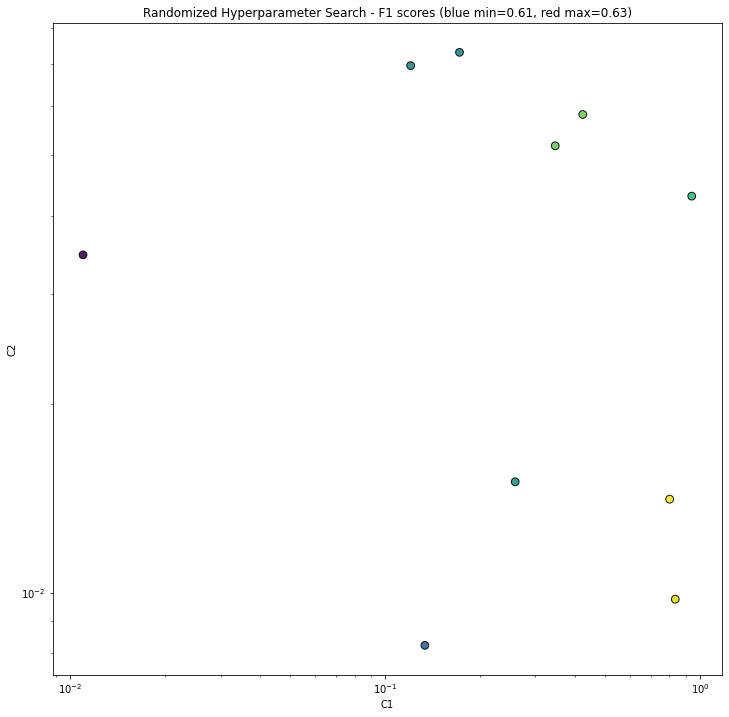

In [22]:
exec_task( word2features_func = task2_word2features, train_crf_model_func = task5_train_crf_model, max_files = max_files, max_iter = max_iter, display_label_subset = display_label_subset )